In [10]:
##+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
## Created by: Jiang-Jiang Liu
## Email: j04.liu@gmail.com
## Copyright (c) 2020
##
## LICENSE file in the root directory of this source tree
##+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

"""SCNet variants"""
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo

__all__ = ['SCNet', 'scnet50', 'scnet101', 'scnet50_v1d', 'scnet101_v1d']

model_urls = {
    'scnet50': 'https://backseason.oss-cn-beijing.aliyuncs.com/scnet/scnet50-dc6a7e87.pth',
    'scnet50_v1d': 'https://backseason.oss-cn-beijing.aliyuncs.com/scnet/scnet50_v1d-4109d1e1.pth',
    'scnet101': 'https://backseason.oss-cn-beijing.aliyuncs.com/scnet/scnet101-44c5b751.pth',
    # 'scnet101_v1d': coming soon...
}

class SCConv(nn.Module):
    def __init__(self, inplanes, planes, stride, padding, dilation, groups, pooling_r, norm_layer):
        super(SCConv, self).__init__()
        self.k2 = nn.Sequential(
            nn.AvgPool2d(kernel_size=pooling_r, stride=pooling_r),
            nn.Conv2d(inplanes, planes, kernel_size=3, stride=1,
                      padding=padding, dilation=dilation,
                      groups=groups, bias=False),
            norm_layer(planes),
        )
        self.k3 = nn.Sequential(
            nn.Conv2d(inplanes, planes, kernel_size=3, stride=1,
                      padding=padding, dilation=dilation,
                      groups=groups, bias=False),
            norm_layer(planes),
        )
        self.k4 = nn.Sequential(
            nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                      padding=padding, dilation=dilation,
                      groups=groups, bias=False),
            norm_layer(planes),
        )

    def forward(self, x):
        identity = x

        k2_out = F.interpolate(self.k2(x), identity.size()[2:]) if x.size()[2] > 1 and x.size()[3] > 1 else self.k2(x)
        out = torch.sigmoid(torch.add(identity, k2_out))  # sigmoid(identity + k2)
        out = torch.mul(self.k3(x), out)  # k3 * sigmoid(identity + k2)
        out = self.k4(out)  # k4

        return out


class SCBottleneck(nn.Module):
    """SCNet SCBottleneck
    """
    expansion = 4
    pooling_r = 4 # down-sampling rate of the avg pooling layer in the K3 path of SC-Conv.

    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 cardinality=1, bottleneck_width=32,
                 avd=False, dilation=1, is_first=False,
                 norm_layer=None):
        super(SCBottleneck, self).__init__()
        group_width = int(planes * (bottleneck_width / 64.)) * cardinality
        self.conv1_a = nn.Conv2d(inplanes, group_width, kernel_size=1, bias=False)
        self.bn1_a = norm_layer(group_width)
        self.conv1_b = nn.Conv2d(inplanes, group_width, kernel_size=1, bias=False)
        self.bn1_b = norm_layer(group_width)
        self.avd = avd and (stride > 1 or is_first)

        if self.avd:
            self.avd_layer = nn.AvgPool2d(3, stride, padding=1
                                          )
            stride = 1

        self.k1 = nn.Sequential(
                    nn.Conv2d(
                        group_width, group_width, kernel_size=3, stride=stride,
                        padding=dilation, dilation=dilation,
                        groups=cardinality, bias=False),
                    norm_layer(group_width),
                    )

        self.scconv = SCConv(
            group_width, group_width, stride=stride,
            padding=dilation, dilation=dilation,
            groups=cardinality, pooling_r=self.pooling_r, norm_layer=norm_layer)

        self.conv3 = nn.Conv2d(
            group_width * 2, planes * 4, kernel_size=1, bias=False)
        self.bn3 = norm_layer(planes*4)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.dilation = dilation
        self.stride = stride

    def forward(self, x):
        residual = x

        out_a= self.conv1_a(x)
        out_a = self.bn1_a(out_a)
        out_b = self.conv1_b(x)
        out_b = self.bn1_b(out_b)
        out_a = self.relu(out_a)
        out_b = self.relu(out_b)

        out_a = self.k1(out_a)
        out_b = self.scconv(out_b)
        out_a = self.relu(out_a)
        out_b = self.relu(out_b)

        if self.avd:
            out_a = self.avd_layer(out_a)
            out_b = self.avd_layer(out_b)

        out = self.conv3(torch.cat([out_a, out_b], dim=1))
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class SCNet(nn.Module):
    """ SCNet Variants Definations
    Parameters
    ----------
    block : Block
        Class for the residual block.
    layers : list of int
        Numbers of layers in each block.
    classes : int, default 1000
        Number of classification classes.
    dilated : bool, default False
        Applying dilation strategy to pretrained SCNet yielding a stride-8 model.
    deep_stem : bool, default False
        Replace 7x7 conv in input stem with 3 3x3 conv.
    avg_down : bool, default False
        Use AvgPool instead of stride conv when
        downsampling in the bottleneck.
    norm_layer : object
        Normalization layer used (default: :class:`torch.nn.BatchNorm2d`).
    Reference:
        - He, Kaiming, et al. "Deep residual learning for image recognition."
        Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.
        - Yu, Fisher, and Vladlen Koltun. "Multi-scale context aggregation by dilated convolutions."
    """
    def __init__(self, block, layers, groups=1, bottleneck_width=32,
                 num_classes=1000, dilated=False, dilation=1,
                 deep_stem=False, stem_width=64, avg_down=False,
                 avd=False, norm_layer=nn.BatchNorm2d):
        self.cardinality = groups
        self.bottleneck_width = bottleneck_width
        # ResNet-D params
        self.inplanes = stem_width*2 if deep_stem else 64
        self.avg_down = avg_down
        self.avd = avd

        super(SCNet, self).__init__()
        conv_layer = nn.Conv2d
        if deep_stem:
            self.conv1 = nn.Sequential(
                conv_layer(3, stem_width, kernel_size=3, stride=2, padding=1, bias=False),
                norm_layer(stem_width),
                nn.ReLU(inplace=True),
                conv_layer(stem_width, stem_width, kernel_size=3, stride=1, padding=1, bias=False),
                norm_layer(stem_width),
                nn.ReLU(inplace=True),
                conv_layer(stem_width, stem_width*2, kernel_size=3, stride=1, padding=1, bias=False),
            )
        else:
            self.conv1 = conv_layer(3, 64, kernel_size=7, stride=2, padding=3,
                                   bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], norm_layer=norm_layer, is_first=False)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, norm_layer=norm_layer)
        if dilated or dilation == 4:
            self.layer3 = self._make_layer(block, 256, layers[2], stride=1,
                                           dilation=2, norm_layer=norm_layer)
            self.layer4 = self._make_layer(block, 512, layers[3], stride=1,
                                           dilation=4, norm_layer=norm_layer)
        elif dilation==2:
            self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                           dilation=1, norm_layer=norm_layer)
            self.layer4 = self._make_layer(block, 512, layers[3], stride=1,
                                           dilation=2, norm_layer=norm_layer)
        else:
            self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                           norm_layer=norm_layer)
            self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                           norm_layer=norm_layer)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, norm_layer):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilation=1, norm_layer=None,
                    is_first=True):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            down_layers = []
            if self.avg_down:
                if dilation == 1:
                    down_layers.append(nn.AvgPool2d(kernel_size=stride, stride=stride,
                                                    ceil_mode=True, count_include_pad=False))
                else:
                    down_layers.append(nn.AvgPool2d(kernel_size=1, stride=1,
                                                    ceil_mode=True, count_include_pad=False))
                down_layers.append(nn.Conv2d(self.inplanes, planes * block.expansion,
                                             kernel_size=1, stride=1, bias=False))
            else:
                down_layers.append(nn.Conv2d(self.inplanes, planes * block.expansion,
                                             kernel_size=1, stride=stride, bias=False))
            down_layers.append(norm_layer(planes * block.expansion))
            downsample = nn.Sequential(*down_layers)

        layers = []
        if dilation == 1 or dilation == 2:
            layers.append(block(self.inplanes, planes, stride, downsample=downsample,
                                cardinality=self.cardinality,
                                bottleneck_width=self.bottleneck_width,
                                avd=self.avd, dilation=1, is_first=is_first,
                                norm_layer=norm_layer))
        elif dilation == 4:
            layers.append(block(self.inplanes, planes, stride, downsample=downsample,
                                cardinality=self.cardinality,
                                bottleneck_width=self.bottleneck_width,
                                avd=self.avd, dilation=2, is_first=is_first,
                                norm_layer=norm_layer))
        else:
            raise RuntimeError("=> unknown dilation size: {}".format(dilation))

        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes,
                                cardinality=self.cardinality,
                                bottleneck_width=self.bottleneck_width,
                                avd=self.avd, dilation=dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def scnet50(pretrained=False, **kwargs):
    """Constructs a SCNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = SCNet(SCBottleneck, [3, 4, 6, 3],
                deep_stem=False, stem_width=32, avg_down=False,
                avd=False, **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['scnet50']))
    return model

def scnet50_v1d(pretrained=False, **kwargs):
    """Constructs a SCNet-50_v1d model described in
    `Bag of Tricks <https://arxiv.org/pdf/1812.01187.pdf>`_.
    `ResNeSt: Split-Attention Networks <https://arxiv.org/pdf/2004.08955.pdf>`_.

    Compared with default SCNet(SCNetv1b), SCNetv1d replaces the 7x7 conv
    in the input stem with three 3x3 convs. And in the downsampling block,
    a 3x3 avg_pool with stride 2 is added before conv, whose stride is
    changed to 1.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = SCNet(SCBottleneck, [3, 4, 6, 3],
                   deep_stem=True, stem_width=32, avg_down=True,
                   avd=True, **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['scnet50_v1d']))
    return model

def scnet101(pretrained=False, **kwargs):
    """Constructs a SCNet-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = SCNet(SCBottleneck, [3, 4, 23, 3],
                deep_stem=False, stem_width=64, avg_down=False,
                avd=False, **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['scnet101']))
    return model

def scnet101_v1d(pretrained=False, **kwargs):
    """Constructs a SCNet-101_v1d model described in
    `Bag of Tricks <https://arxiv.org/pdf/1812.01187.pdf>`_.
    `ResNeSt: Split-Attention Networks <https://arxiv.org/pdf/2004.08955.pdf>`_.

    Compared with default SCNet(SCNetv1b), SCNetv1d replaces the 7x7 conv
    in the input stem with three 3x3 convs. And in the downsampling block,
    a 3x3 avg_pool with stride 2 is added before conv, whose stride is
    changed to 1.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = SCNet(SCBottleneck, [3, 4, 23, 3],
                   deep_stem=True, stem_width=64, avg_down=True,
                   avd=True, **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['scnet101_v1d']))
    return model


if __name__ == '__main__':
    images = torch.rand(2, 3, 224, 224).cuda(0)
    model = scnet101(pretrained=True)
    model = model.cuda(0)
    print(model(images).size())

torch.Size([2, 1000])


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
# Function to train and evaluate the model
def train_and_evaluate_model(model, trainloader, testloader, num_epochs, learning_rate):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(trainloader)}")

    # Evaluation loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f"Accuracy on the test set: {100 * accuracy:.2f}%")

# Load the dataset (example: CIFAR-10)
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Create an instance of the SCNet model (you can choose a different variant)
scnet_model = scnet50(pretrained=True)  # You can set pretrained=False if you want to train from scratch

# Set hyperparameters
num_epochs = 10
learning_rate = 0.001

# Train and evaluate the model
train_and_evaluate_model(scnet_model, trainloader, testloader, num_epochs, learning_rate)

Files already downloaded and verified
Files already downloaded and verified


Downloading: "https://backseason.oss-cn-beijing.aliyuncs.com/scnet/scnet50-dc6a7e87.pth" to /root/.cache/torch/hub/checkpoints/scnet50-dc6a7e87.pth
100%|██████████| 97.9M/97.9M [00:04<00:00, 23.0MB/s]


Epoch 1/10, Loss: 1.3196057215371095
Epoch 2/10, Loss: 0.9412890056057659
Epoch 3/10, Loss: 0.8243881848157214
Epoch 4/10, Loss: 0.7474262302031602
Epoch 5/10, Loss: 0.6988078552057676
Epoch 6/10, Loss: 0.6428382329242613
Epoch 7/10, Loss: 0.6121239423027733
Epoch 8/10, Loss: 0.5906264365024274
Epoch 9/10, Loss: 0.5702978616289776
Epoch 10/10, Loss: 0.5414880593414502
Accuracy on the test set: 80.11%


Test Accuracy of the Best Model on the Test Dataset: 80.27%


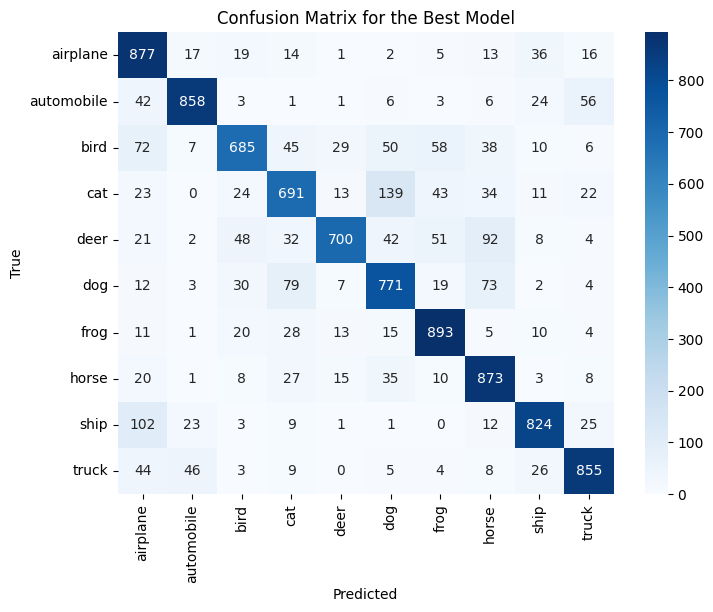

In [18]:
import torch
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'scnet_model' is your trained model
best_model = scnet_model

# Assuming 'testloader' is your DataLoader for the test set
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
best_model.to(device)
best_model.eval()

test_accuracy = 0.0
all_predictions = []
all_targets = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().tolist())  # Move predictions to CPU
        all_targets.extend(labels.cpu().tolist())  # Move targets to CPU

# Calculate and print test accuracy
test_accuracy = accuracy_score(all_targets, all_predictions) * 100
print("Test Accuracy of the Best Model on the Test Dataset: {:.2f}%".format(test_accuracy))

# Assuming 'class_names' is your list of class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Calculate and plot confusion matrix
confusion = confusion_matrix(all_targets, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for the Best Model')
plt.show()
